### Slider control of `Common Rig`

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import MultiSliderClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Parse `scene_common_rig.xml`

In [2]:
xml_path = '../asset/myo_sim/human/myohuman_v0.1(mj236).mjb'
env = MuJoCoParserClass(name='Common Rig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[83]
n_geom:[82]
geom_names:['floor', 'r_pelvis', 'l_pelvis', 'sacrum', 'r_femur', 'r_tibia', 'r_fibula', 'r_talus', 'r_foot', 'r_bofoot', 'r_patella', 'l_femur', 'l_tibia', 'l_fibula', 'l_talus', 'l_foot', 'l_bofoot', 'l_patella', 'hat_spine', 'hat_jaw', 'hat_skull', 'hat_ribs_scap', 'humerus_r', 'ulna', 'radius', 'lunate', 'scaphoid', 'pisiform', 'triquetrum', 'capitate', 'trapezium', '1mc', 'thumbprox', 'thumbdist', 'trapezoid', 'hamate', '2mc', '2proxph', '2midph', '2distph', '3mc', '3proxph', '3midph', '3distph', '4mc', '4proxph', '4midph', '4distph', '5mc', '5proxph', '5midph', '5distph', 'humerus_lv', 'ulna_l', 'radius_l', 'lunate_l', 'scaphoid_l_geom_1', 'pisiform_l_geom_1', 'triquetrum_l_geom_1', 'capitate_l_geom_1', 'trapezium_l_geom_1', 'firstmc_l_geom_1', 'proximal_thumb_l_geom_1', 'distal_thumb_l_geom_1', 'trapezoid_l_geom_1', 'hamate_l_geom_1', 'secondmc_l_geom_1', '2proxph_l_geom_1', '2midph_l_geom_1', '2distph_l_geom_1', 'thirdmc_l_geom_

### Loop

In [3]:
# Initialize sliders for joint control
rev_joint_names = env.rev_joint_names
idxs_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
q_rev = env.get_qpos_joints(rev_joint_names)
n_rev_joint = len(rev_joint_names)

sliders = MultiSliderClass(
    n_slider      = n_rev_joint,
    title         = 'Sliders for Common Rig Control',
    window_width  = 500,
    window_height = 800,
    x_offset      = 300,
    y_offset      = 100,
    slider_width  = 350,
    label_texts   = rev_joint_names,
    slider_mins   = env.rev_joint_mins,
    slider_maxs   = env.rev_joint_maxs,
    slider_vals   = q_rev,
    resolution    = 0.01,
    VERBOSE       = False
)
for _ in range(100): sliders.update() # to avoid GIL-related error

2023-09-06 14:31:33.161 python[38134:4962146] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


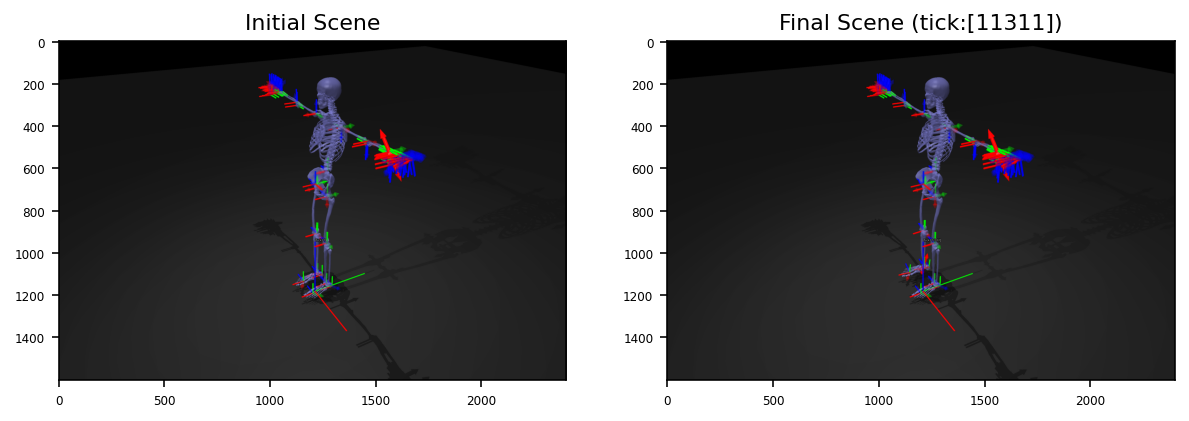

In [4]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
# Reset and loop
env.reset()
FIRST_FLAG = True
while env.is_viewer_alive() and sliders.is_window_exists():
    # Simulate
    sliders.update() # update slider control
    q_fwd = sliders.get_slider_values()
    env.forward(q=q_fwd,joint_idxs=idxs_fwd,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        
        # Plot revolute joints with arrow
        for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
            axis_joint = env.model.jnt_axis[rev_joint_idx]
            p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
            axis_world = R_joint@axis_joint
            axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
            axis_len,axis_r = 0.1,0.01
            env.plot_arrow_fr2to(
                p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
                r=axis_r,rgba=axis_rgba)
        # Plot contact information
        env.plot_contact_info(h_arrow=0.3,rgba_arrow=[1,0,0,1],
                              PRINT_CONTACT_BODY=False)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer and sliders
env.close_viewer()
sliders.close()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()